In [1]:
def MO(Tair,Tsurface,Eair,Esurface,wsp):
    ## Constants and derived values
    z0 = .005  # Assume a momentum roughness length of .005m
    z0h = z0  # Assume a water vapor flux characteristic length of .005m
    z0q = z0  # Assume a temperature flux characteristic length of .005m
    H = 2.  # Assume measurement 2m above snow
    dlogT = np.log(H/z0h)
    dlogQ = np.log(H/z0q)
    # Computes drag coefficient over snow at neutral stability
    dlogW = np.log(H/z0)
    Rw = 461.296  # Gas constant for water vapor [J/kg-K]
    Ck = 0.  # Windless exchange coefficient for water vapor [Wm**-2]
    Csk = 2.  # Windless exchange coefficient for heat [Wm**-2]
    cdryair = 1005.  # Specific heat of dy air [J kg**-1 K**-1]

    # Use values at neutral stability for first guess 
    Psim = 0.
    Psih = 0.
    Psiq = 0.
    deltaT = Tair - Tsurface
    deltaE = Eair - Esurface
    Tbar = (Tair + Tsurface)/2.
    Rbw = 9.8 * H * deltaT/(Tbar*wsp**2.)
    zetat = Rbw * dlogW
    L = H/zetat
    # Gas constant for dry air (287J/kg-K) is from "Handbook of 
    # Meteorology,"Berry, et al, 1945, McGraw-Hill, p. 353.
    rhoair = 1.2
    con = 100./(Rw*Tair*rhoair)
    freelim = 0.
    freelimv = 0.

    ## Code 
    # Compute stability functions using iterative solution.
    # Next begins Newton-Raphson iterative loop.  Loop at least twice.
    for it in np.arange(0,51):
        if it == 0:
            ## Initial pass
            if Rbw > 1.427:
                # Exceeds critical Richardson number
                qsen0= 1.*10.**-12.
                qlat0= 1.*10.**-12.
                break
            if L >= 0:
                # Bounds on zetat for N-R scheme
                zetal = 0.
                zetah = 500.

        ## a. Compute momentum stability functions, Cd, and wstar
        zeta = H/L
        if L >= 0.:
            # Stable   
            Psim = Dutch(zeta)
        else:
            # Unstable 
            Psim = Unstable(L,H,z0h,1)

        sqrtCd = 0.4/max((dlogW - Psim),0.1)
        wstar = sqrtCd * wsp
        
        ## b. Estimate scalar roughness lengths and stability functions
        [z0h,z0q,dlogQ,dlogT] = andreas(wstar,z0,Tair,H)
        if L >= 0:
            # Stable   
            Psih=Psim
            PsimT=Psih
            Psiq=Psih
        else:
            # Unstable 
            PsimT=Unstable(L,H,z0h,1)
            psih=Unstable(L,H,z0h,2)
            psiq=psih
        tstar = 0.4 * deltaT/(dlogT - Psih)
        qstar = 0.4 * deltaE*con/ (dlogQ - Psiq)

        ## c. Compute Monin-Obukhov length (L)
        if not tstar == 0. and not wstar == 0.: 
            L = 1 + 0.61 * Tbar*qstar/tstar
            dum=L
            L = L * 9.8 * 0.4 * tstar/ (Tbar* wstar**2.)
            L=1./L
        elif tstar == 0. and wstar == 0.:
            L=1.*10.**14.

        ## d. Limits for extremely stable and unstable stratification 
        if (zetat > 500.) or (H/L > 500.):
            # Very stable
            qsen0 = 1.*10.**-12.
            qlat0 = 1.*10.**-12.

        elif L < 0. and L > -1.0:
            # Very unstable:
            # Compute free convection limits.  Applies generally for L < -0.1
            # Andreas and Cash, Convective heat transfer over wintertime
            # leads and polynyas, JGR 104, C11, 25,721-25,734, 1999.
            # Method is for a smooth surface with unlimited fetch.
            deltaB = (-9.8 * deltaT / Tbar) * dum
            nu = 1.315*10.**-5.  # Kinematic viscosity of air
            D = 0.024 / (cdryair * rhoair)
            Dv = 1.1494*D
            zscale = (nu*D/deltaB)**(1./3.)
            zscalev = (nu*Dv/deltaB)**(1./3.)
            freelim = -0.15 *rhoair * cdryair * D * deltaT /zscale
            freelimv = -0.15 * Dv * deltaE * con * 2.838*10.**6./zscalev

        ## e. Compute change in zeta)
        y = (H/L) - zetat
        if L > 0. and  y >  0.:
            zetal = zetat  # Update lower bound
        elif L > 0. and y <= 0.:
            zetah=zetat  # Update upper bound
        if np.abs(y) < 1.*10.**-2. and it > 2:
            # Within tolerance and more than one iteration executed, leave loop
            qlat0 = fqlat(dlogW,dlogQ,Rw,Tair,Psim,Psiq,wsp)
            qsen0 = fqsen(dlogW,dlogT,cdryair,rhoair,Psim,Psih,wsp)
            break
        if it == 49:
            # NOT within tolerance and more than 50 iterations executed, leave loop
            qlat0 = fqlat(dlogW,dlogQ,Rw,Tair,Psim,Psiq,wsp)
            qsen0 = fqsen(dlogW,dlogT,cdryair,rhoair,Psim,Psih,wsp)
            print('Convergence problem in QTURB') 
            break

        ## f. Use Newton-Raphson scheme for stable, sequential estimates for unstable
        if L >= 0:
            # Next is derivitive of Psi
            DpsitDzetat = -0.70 - 0.75 * np.exp(-0.35 * zetat)*(6 - 0.35 * zetat)
            DpsimDzetat = -0.70 - 0.75 * np.exp(-0.35 * zeta)*(6 - 0.35 * zeta)
            dumM = 1./ (dlogW-Psim)
            dumT = 1. / (dlogT-Psih)
            # Next is derivitive of y (ignoring humidity effects)
            yprime = (H/L) * (DpsitDzetat * dumT - 2. * DpsimDzetat * dumM) - 1.
            zetat = zetat - (y/yprime)
            if zetat <= zetal or zetat >= zetah:
                # Root out of range. Bisection instead of Newton-Raphson scheme
                zetat = (zetah+zetal)/2.
        else:
            zetat = H/L
        L = H/zetat

    ## Final computation of qsen and qsen. 
    # Note qlat and qsen add the windless coefficients and qlat is times
    # the latent heat of sublimation or evaporation.
    # For dry snow, use latent heat of sublimation
    qlat = Ck + qlat0 *2.838*10.**6.
    if L >= 0:

        qsen=qsen0

        if qsen0 < max(Csk,.1) and qsen0 > 0.:
            # Minimum value
            qsen = max(Csk,.1)
    else:
        dum = 0.
        if not deltaT == 0.:
            dum=-freelim/deltaT
        qsen = max(qsen0,dum)

        dum = 0.
        if deltaE == 0.:
            dum = -freelimv/deltaE
        qlat = max(qlat,dum)
    ## Compute bulk Richardson number
    # First adjust windspeed to height of temperature measurement
    if  L > 0.:
        PsimT = Psih
    else:
        PsimT = Unstable(L,H,z0h,1)
    wspT = (wsp/ (dlogW - Psim)) * (np.log(H/z0)-PsimT)
    Rb = 9.8 * H * deltaT / (Tbar*wspT**2)

    ## Convert to fluxes
    qsen = qsen * (Tair - Tsurface)
    qlat = qlat * (Eair - Esurface)
    
    return (qsen, qlat)

In [2]:
#***********************************************************************
## Sub-funcitons
#***********************************************************************

def fqsen(dlogW,dlogT,cdryair,rhoair,Psim,Psih,wsp):
    sen = cdryair*rhoair*wsp*0.16/((dlogW - Psim)*(dlogT - Psih))
    return sen  

def fqlat(dlogW,dlogQ,Rw,tkair,psim,psiq,wsp):
# Since vapor pressure is in mb, fqlat is multiplied by 100 to
# convert to Pascals
    # Wind coefficient
    lat = wsp*0.16*10.**2./(Rw*tkair*(dlogW - psim)*(dlogQ - psiq))
    return lat

def Dutch(zeta):
    stab = -(0.70* zeta + 0.75 *(zeta-14.28) * np.exp(-0.35*zeta)  + 10.71)
    return stab

def Unstable(L,Ht,zt,icall):
    # Set an upper limit on function at L = -.1 or  at 200 times
    # the large -Ht/L limit where np.log(-4*Ht/L) is 0.  This asymptotic
    # limit is from Godfrey and Beljaars (1991).  This is a semi-
    # empirical fix to keep the heat flux from increasing with 
    # decreasing -L.
    Llim = np.min(-.1,-100.*zt)
    zeta = Ht / np.min(L,Llim)
    x = (1.-16.*zeta)**0.25
    if icall <= 1:     
        stab = np.log((1+x*x)/2)+2 * np.log((1.+x)/2) - 2.*np.arctan(x) + 1.5707963
    else:     
        stab = 2.*np.log((1.+x*x)/2.)
    return stab

def andreas(wstar,z0,Tkair,H):
#    Compute scaler roughness lengths using procedure
#    in Andreas, 1987, Boundary-Layer Meteorology 38, 159-184.  Only
#    use this procedure for snow.

#     Expression for kinematic viscosity of air is taken from program
#     of Launiainen and Vihma, 1990, Environmental Software, vol. 5,
#     No. 3, pp. 113 - 124.

# Heat
    Reynolds = z0*wstar*1.*10.**7./(.9065*Tkair-112.7)
    if Reynolds <= 0.135:
        # Smooth coefficients
        b0=1.250
        b1=0.
        b2=0.
    elif Reynolds < 2.5:
        # Transition coefficients
        b0=0.149
        b1=-0.550
        b2=0.
    else:
        # Rough coefficients
        b0=0.317
        b1=-0.565
        b2=-0.183
    dlogReynolds = np.log(Reynolds)
    dlogsqrd = dlogReynolds * dlogReynolds
    dum= b0 + b1*dlogReynolds + b2*dlogsqrd
    z0h = z0*np.exp(dum)

    # Moisture 
    if Reynolds <= 0.135:
        b0=1.61
        b1=0.
        b2=0.
    elif Reynolds < 2.5:
        b0=0.351
        b1=-0.628
        b2=0.
    else:
        b0=0.396
        b1=-0.512
        b2=-0.180
    dum = b0 + b1 * dlogReynolds + b2*dlogsqrd
    z0q = z0*np.exp(dum)

    # Log profiles
    dlogT = np.log(H/z0h)
    dlogQ= np.log(H/z0q)

    return (z0h, z0q, dlogQ, dlogT)

In [3]:
import numpy as np
import turbpy

Tsurface = 253.15
airT = np.arange(-5, 20, .1) + Tsurface  # Air temperature in [K]
RH = .7  # Relative humidity
wsp = 1. # Wind speed

# Water vapor partial pressure (hPa?)
Eair,_ = turbpy.conversionTools.satVapPress(airT-273)
Eair = Eair / 100.
Esurface,_ =turbpy.conversionTools.satVapPress(Tsurface-273)
Esurface = Esurface / 100.

sensible = np.zeros_like(airT)
latent = np.zeros_like(airT)

for n,(T,vp) in enumerate(zip(airT,Eair)):
    (sensible[n],latent[n]) = MO(T,Tsurface,vp,Esurface,wsp)


Convergence problem in QTURB
Convergence problem in QTURB
Convergence problem in QTURB
Convergence problem in QTURB
Convergence problem in QTURB
Convergence problem in QTURB
Convergence problem in QTURB
Convergence problem in QTURB
Convergence problem in QTURB
Convergence problem in QTURB
Convergence problem in QTURB
Convergence problem in QTURB
Convergence problem in QTURB
Convergence problem in QTURB


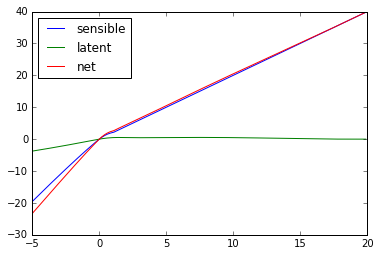

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(airT - Tsurface, sensible,label='sensible')
plt.plot(airT - Tsurface, latent,label='latent')
plt.plot(airT - Tsurface, sensible + latent, label='net')
plt.gca().legend(loc='best')

In [5]:
import turbpy.multiConst as mc
def moninObukhov(airTemp, sfcTemp, airVaporPress, sfcVaporPress, windspd, z0Ground=.005):
    # Assume that surface drag parameter is equal
    # between momentum, heat, and moisture
    z0Groundw = z0Ground
    z0Groundh = z0Ground
    z0Groundq = z0Ground
    # log gradient for temperature, moisture, and wind
    dlogT = np.log(mHeight / z0Groundh)
    dlogQ = np.log(mHeight / z0Groundq)
    dlogW = np.log(mHeight / z0Groundw)

    # Iteration control
    numMaxIterations = 50       # Number of iterations for convergence
    itTolerance = 1. * 10**(-2)  # Tolerance iterative solution
    # Bounds on zetaT for N-R scheme
    zetaLow = 0.
    zetaHigh = 500.

    # Initial Values: assume neutral stability for first guess
    psiM = 0.					# Stability function for momentum
    psiH = 0.					# Stability function for heat
    psiQ = 0.					# Stability function for water vapor
    deltaT = airTemp - sfcTemp
    deltaE = (airVaporPress - sfcVaporPress) / 100.  # Convert [Pa] -> [hPa]
    Tbar = (airTemp + sfcTemp) / 2.
    zetaT = RiBulk * dlogW      # Stability parameter
    L = mHeight / zetaT 		# Obukhov height

    ########
    # Iterative solution to CH,CD, and L
    for it in np.arange(0, numMaxIterations):
        # Newton-Raphson iterative loop. Loop at least twice.
        if it == 0:
            # Initial pass
            if RiBulk > 1.427:
                # Exceeds critical Richardson number
                # Decouple the atmosphere and land surface
                conductanceSensible = mc.machineEpsilon
                conductanceLatent = mc.machineEpsilon

                moninObukhovParameters = {'L': L,
                                          'psiM': psiM,
                                          'psiH': psiH,
                                          'psiQ': psiQ,
                                          'zeta': mHeight / L,
                                          'zetaT': zetaT,
                                          'freelim': 0.,
                                          'freelimv': 0.,
                                          }
                moninObukhovDerivatives = {}
                return (moninObukhovParameters, moninObukhovDerivatives,
                        conductanceSensible, conductanceLatent)

        #########
        # a. Compute momentum stability functions, transfer coefficient Cd,
        # and friction veolocity ustar
        zeta = mHeight / L
        if L >= 0.:
            # Stable
            psiM = Dutch(zeta)
        else:
            # Unstable
            psiM = Unstable(L, mHeight, z0Groundh, 1)
        sqrtCd = mc.vkc / max((dlogW - psiM), 0.1)
        ustar = sqrtCd * windspd

        #########
        # b. Estimate scalar roughness lengths (zh, zq,and zm) and
        # stability functions (heat and moisture)
        #
        # Assumes that measurement height for temperature and
        # water vapor are made at the same height as wind. If this
        # assumption is broken, psiQ and psiH need be calculated
        # using the "Dutch" function.
        [z0Groundh, z0Groundq, dlogQ, dlogT] = \
            andreas(ustar, z0Ground, airTemp, mHeight)
        if L >= 0.:
            # Stable
            psiH = psiM
            psiQ = psiH
        else:
            # Unstable
            psiH = Unstable(L, mHeight, z0Groundh, 2)
            psiQ = psiH
        # Scalar lengths for temperature and moisture
        tstar = mc.vkc * deltaT / (dlogT - psiH)
        qstar = (mc.vkc * deltaE * 100
                 / (mc.R_wv * airTemp * mc.iden_air)
                 / (dlogQ - psiQ))

        #########
        # c. Compute Monin-Obukhov length (L)
        if (not tstar == 0.) and (not ustar == 0.):
            # These expressions from SNTHERM are combined below in `L`
            # They seem similar to B6.22, but do not match exactly...
            # L = 1 + 0.61 .* Tbar.*qstar./tstar;
            # dum=L;
            # L = L .* 9.8 .* 0.4 .* tstar./ (Tbar.* wstar.^2);
            # L=1/L;
            B0 = (1. + 0.61 * Tbar * qstar / tstar)
            L = (1. / (B0
                       * (mc.gravity * mc.vkc * tstar)
                       / (Tbar * ustar**2.)
                       )
                 )
        elif (tstar == 0.) and (not ustar == 0.):
            # Extremely stable, decouple the land surface
            L = 1. * 10.**14.

        #########
        # d. Limits for extremely stable and unstable stratification
        freelim = 0
        freelimv = 0
        if zetaT > 500 or mHeight / L > 500:
            # Very stable
            # Decouple the atmosphere and land surface
            conductanceSensible = mc.machineEpsilon
            conductanceLatent = mc.machineEpsilon
            moninObukhovParameters = {'L': L,
                                      'psiM': psiM,
                                      'psiH': psiH,
                                      'psiQ': psiQ,
                                      'zeta': zeta,
                                      'zetaT': zetaT,
                                      'freelim': freelim,
                                      'freelimv': freelimv,
                                      }
            moninObukhovDerivatives = {}
            return (moninObukhovParameters, moninObukhovDerivatives,
                    conductanceSensible, conductanceLatent)

        elif L < 0. and L > -1.0:
            # Very unstable:
            # Compute free convection limits.  Applies generally for L < -0.1
            # Andreas and Cash, Convective heat transfer over wintertime
            # leads and polynyas, JGR 104, C11, 25,721-25,734, 1999.
            # Method is for a smooth surface with unlimited fetch.

            # Difference in bouyancy flux
            deltaB = -(mc.gravity * deltaT / Tbar) * B0
            # Kinematic viscosity of air
            nu = 1.315 * 10**(-5.)
            D = 0.024 / (mc.Cp_air * mc.iden_air)
            Dv = 1.1494 * D

            zscale = (nu * D / deltaB)**(1. / 3.)
            zscalev = (nu * Dv / deltaB)**(1. / 3.)
            freelim = -0.15 * mc.iden_air * mc.Cp_air * D * deltaT / zscale

            # Commented code handles non-snow covered surfaces...
            # if scalarGroundSnowFraction == 1:
            freelimv = (-0.15 * Dv * deltaE * 2.838 * 10**(6.)
                        / (zscalev * mc.R_wv * airTemp * mc.iden_air)
                        )
            # else:
            #   freelimv=(dlogT/dlogQ)*freelimv

        ########
        # e. Compute change in zeta
        y = (mHeight / L) - zetaT
        if (L > 0.) and (y > 0.):
            # Update lower bound
            zetaLow = zetaT
        elif (L > 0.) and (y <= 0.):
            # Update upper bound
            zetaHigh = zetaT

        if (np.abs(y) < itTolerance) and (it >= 2):
            # Within tolerance, leave loop
            conductanceSensible = (mc.vkc**2.
                                   / ((dlogW - psiM) * (dlogT - psiH)))
            conductanceLatent = (mc.vkc**2.
                                 / ((dlogW - psiM) * (dlogQ - psiQ)))
            # Collect MOST related parameters for use outside function
            moninObukhovParameters = {'L': L,
                                      'psiM': psiM,
                                      'psiH': psiH,
                                      'psiQ': psiQ,
                                      'zeta': zeta,
                                      'zetaT': zetaT,
                                      'freelim': freelim,
                                      'freelimv': freelimv,
                                      }
            moninObukhovDerivatives = {}
            return (moninObukhovParameters, moninObukhovDerivatives,
                    conductanceSensible, conductanceLatent)
        if it >= numMaxIterations - 1:
            # NOT within tolerance, leave loop
            conductanceSensible = (mc.vkc**2.
                                   / ((dlogW - psiM) * (dlogT - psiH)))
            conductanceLatent = (mc.vkc**2.
                                 / ((dlogW - psiM) * (dlogQ - psiQ)))
            # Alert the user
            print('Convergence problem in turbpy.aStability.moninObukhov')
            # Collect MOST related parameters for use outside function
            moninObukhovParameters = {'L': L,
                                      'psiM': psiM,
                                      'psiH': psiH,
                                      'psiQ': psiQ,
                                      'zeta': zeta,
                                      'zetaT': zetaT,
                                      'freelim': freelim,
                                      'freelimv': freelimv,
                                      }
            moninObukhovDerivatives = {}
            return (moninObukhovParameters, moninObukhovDerivatives,
                    conductanceSensible, conductanceLatent)
        #########
        # f. Use Newton-Raphson scheme for stable
        # sequential estimates for unstable
        if L >= 0.:
            # Next is derivative of Psi
            DpsitDzetaT = (-0.70 - 0.75
                           * np.exp(-0.35 * zetaT)
                           * (6. - 0.35 * zetaT)
                           )
            DpsiMDzetaT = (-0.70 - 0.75
                           * np.exp(-0.35 * zeta)
                           * (6. - 0.35 * zeta))
            dumM = 1. / (dlogW - psiM)
            dumT = 1. / (dlogT - psiH)
            # Derivative of y (ignoring humidity effects)
            yprime = ((mHeight / L)
                      * ((DpsitDzetaT * dumT)
                         - (2. * DpsiMDzetaT * dumM)
                         )
                      - 1.
                      )
            zetaT = zetaT - (y / yprime)
            if (zetaT <= zetaLow) or (zetaT >= zetaHigh):
                # Root out of range. Bisection instead of Newton-Raphson
                zetaT = (zetaHigh + zetaLow) / 2.
            else:
                zetaT = mHeight / L
            # Update Obukhov length
            L = mHeight / zetaT

# ------------------------------------------------------------------------------
# Sub-functions to Monin-Obukhov
# ------------------------------------------------------------------------------
def Unstable(L, Ht, zt, icall):
    # Set an upper limit on function at L = -.1 or  at 200 times
    # the large -Ht/L limit where log(-4*Ht/L) is 0.  This asymptotic
    # limit is from Godfrey and Beljaars (1991).  This is a semi-
    # empirical fix to keep the heat flux from increasing with
    # decreasing -L.
    Llim = np.min(-.1, -100. * zt)
    zeta = mHeight / np.min(L, Llim)
    x = (1. - 16. * zeta)**(0.25)
    if icall == 1:
        stab = (np.log((1 + x**2.) / 2.)
                + 2. * np.log((1. + x) / 2.)
                - 2. * np.arctan(x) + 1.5707963)
    else:
        stab = 2. * np.log((1. + x**2.) / 2.)
    return stab

# ------------------------------------------------------------------------------
def Dutch(zeta):
    stab = (-(0.70 * zeta
            + 0.75 * (zeta - 14.28)
            * np.exp(-0.35 * zeta)
            + 10.71))
    return stab

# ------------------------------------------------------------------------------
def andreas(ustar, z0Ground, airTemp, mHeight):
    #    Compute scaler roughness lengths using procedure
    #    in Andreas, 1987, Boundary-Layer Meteorology 38, 159-184.  Only
    #    use this procedure for snow.
    #
    #     Expression for kinematic viscosity of air is taken from program
    #     of Launiainen and Vihma, 1990, Environmental Software, vol. 5,
    #     No. 3, pp. 113 - 124.

    # Heat
    Reynolds = z0Ground * ustar * 1. * 10.**7. / (.9065 * airTemp - 112.7)
    if Reynolds <= 0.135:
        # Smooth coefficients
        b0 = 1.250
        b1 = 0.
        b2 = 0.
    elif Reynolds < 2.5:
        # Transition coefficients
        b0 = 0.149
        b1 = -0.550
        b2 = 0.
    else:
        # Rough coefficients
        b0 = 0.317
        b1 = -0.565
        b2 = -0.183
    z0Groundh = (z0Ground
                 * np.exp(b0
                          + b1 * np.log(Reynolds)
                          + b2 * np.log(Reynolds)**2.))

    # Moisture
    if Reynolds <= 0.135:
        b0 = 1.61
        b1 = 0.
        b2 = 0.
    elif Reynolds < 2.5:
        b0 = 0.351
        b1 = -0.628
        b2 = 0.
    else:
        b0 = 0.396
        b1 = -0.512
        b2 = -0.180
    z0Groundq = (z0Ground
                 * np.exp(b0
                          + b1 * np.log(Reynolds)
                          + b2 * np.log(Reynolds)**2.
                          )
                 )

    # Log profiles
    dlogT = np.log(mHeight / z0Groundh)
    dlogQ = np.log(mHeight / z0Groundq)

    return (z0Groundh, z0Groundq, dlogQ, dlogT)

def surfFlux(airTemp, airVaporPress, sfcTemp, sfcVaporPress,
                 stabilityCorrectionParameters, senHeatGround0, latHeatGround0,
                 conductanceSensible, conductanceLatent):

    # Windless exchange coefficients for water vapor, k, and heat, sk [Wm^-2]
    Ck = 0
    Csk = 2

    # Unpack parameters from aStability.moninObukhov
    L = stabilityCorrectionParameters['L']
    freelim = stabilityCorrectionParameters['freelim']
    freelimv = stabilityCorrectionParameters['freelimv']

    # Gradients in temperature and water vapor
    deltaT = airTemp - sfcTemp
    deltaE = airVaporPress - sfcVaporPress

    # Calculate sensible and latent heat fluxes.
    # Note that the fluxes include the windless exchange coefficients.
    latHeatGround = Ck + latHeatGround0
    if L >= 0:
        senHeatGround = senHeatGround0
        if senHeatGround0 < max(Csk, .1) and senHeatGround0 > 0:
            # Enforce a minimum value.
            senHeatGround = max(Csk, .1)
    else:
        # Sensible heat maximum for unstable
        dum = 0
        if not deltaT == 0:
            dum = -freelim / deltaT
        senHeatGround = np.max(senHeatGround0, dum)

        # Latent heat maximum for unstable
        dum = 0
        if not deltaE == 0:
            dum = -freelimv / deltaE
        latHeatGround = max(latHeatGround, dum)

    ## Convert to fluxes
    senHeatGround = senHeatGround * deltaT
    latHeatGround = latHeatGround * deltaE
        
    return (senHeatGround, latHeatGround)


In [6]:
sfcTemp = 253.15
airTemp = 273.  # Air temperature in [K]
RH = .7  # Relative humidity
windspd = 1. # Wind speed

# Water vapor partial pressure (hPa?)
airVaporPress,_ = turbpy.conversionTools.satVapPress(airTemp-273)
airVaporPress = airVaporPress / 100.
sfcVaporPress,_ = turbpy.conversionTools.satVapPress(sfcTemp-273)
sfcVaporPress = sfcVaporPress / 100.
mHeight = 2.
RiBulk, _, _ = turbpy.bulkRichardson(airTemp, sfcTemp, windspd, mHeight, False)
    
(stabilityCorrectionParameters, stabilityCorrectionDerivatives, conductanceSensible, conductanceLatent) = \
    moninObukhov(airTemp, sfcTemp, airVaporPress, sfcVaporPress, windspd, z0Ground=.005)


########
# Local variables
volHeatCapacityAir = mc.iden_air * mc.Cp_air              # volumetric heat capacity of air (J m-3)
latentHeatConstant = mc.iden_air * mc.w_ratio / 101000   # latent heat constant for (kg m-3 Pa-1)

#######
# Latent Heat - Vaporization or sublimation.
# NOTE: The physics implied here may be wrong. Point to bring up with Martyn/Bart
latHeatSubVapGround = mc.LH_sub  # sublimation from snow
    
senHeatGround0 = volHeatCapacityAir * conductanceSensible
latHeatGround0 = latHeatSubVapGround * latentHeatConstant * conductanceLatent
    
senHeatGround, latHeatGround = surfFlux(airTemp, airVaporPress,
                                            sfcTemp, sfcVaporPress, stabilityCorrectionParameters,
                                            senHeatGround0, latHeatGround0,
                                            conductanceSensible, conductanceLatent)

In [7]:
Tsurface = sfcTemp
airT = airTemp  # Air temperature in [K]
wsp = windspd # Wind speed

# Water vapor partial pressure (hPa?)
Eair = airVaporPress
Esurface = sfcVaporPress

(sensible,latent) = MO(airT,Tsurface,Eair,Esurface,wsp)


In [8]:
# Verify that the direct conversion of the MO code from SNTHERM matches the refactored code used in the turbpy package
print(sensible)
print(senHeatGround)

39.7
39.7
